In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold

import pickle

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.pipeline import make_pipeline

import pickle

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

In [6]:
df = pd.read_parquet('/kaggle/input/sberdataset/train_ai_comp_final_dp.parquet')
df_test = pd.read_parquet('/kaggle/input/sberdataset/test_sber.parquet')
test_ids = df_test.id

In [7]:
feat = ['feature193', 'feature862', 'feature358', 'feature472', 'feature154', 'feature937', 'feature195',
        'feature1035','feature572', 'feature187', 'feature6', 'feature322', 'feature226', 'feature985',
        'feature918', 'feature46','feature917', 'feature548', 'feature287', 'feature916', 'feature715',
        'feature189', 'feature444', 'feature755', 'feature989', 'feature156', 'feature546', 'feature262',
        'feature435', 'feature898', 'feature210', 'feature991', 'feature939', 'feature342', 'feature443',
        'feature938', 'feature94', 'feature922', 'feature1069', 'feature534', 'feature543', 'feature310',
        'feature945', 'feature350', 'feature1036', 'feature861', 'feature191', 'feature35', 'feature349',
        'feature941', 'feature1', 'feature713', 'feature988', 'feature920', 'feature309', 'feature1002',
        'feature192', 'feature357', 'feature935', 'feature944', 'feature936', 'feature356', 'feature320',
        'feature993', 'feature990', 'feature940', 'feature952', 'feature318', 'feature341', 'feature1004']

X = df[feat]
y = df.target
X_test = df_test[feat]

In [8]:
n_unique = X.nunique()

cat_features = []
for column in X.columns:
    if n_unique.loc[column] < 30:
        cat_features.append(column)
        
cat_features

['feature985',
 'feature715',
 'feature444',
 'feature755',
 'feature435',
 'feature443',
 'feature713']

In [9]:
continuous_features = []

for column in X.columns:
    if n_unique.loc[column] > 300000:
        continuous_features.append(column)
        
len(continuous_features)

16

In [10]:
other = []

for column in X.columns:
    if (column not in continuous_features) & (column not in cat_features):
        other.append(column)
        
len(other)

47

In [11]:
mode_count_threshold = 0.3
modes_col = []
modes = X.mode().iloc[0]

for column in other:
    
    mode_count = (X[column] == modes[column]).sum()
    total_count = len(X)
    
    if mode_count / total_count > mode_count_threshold:
        
        modes_col.append((column, modes[column]))
        X.loc[:, column] = (X[column] == modes[column]).astype('int8')

In [12]:
for col in modes_col:
    X_test.loc[:, col[0]] = X_test[col[0]] == col[1]

In [13]:
def generate_ratio_features(df):
    ratio_features = {}

    for i in range(len(continuous_features)):

        for j in range(i + 1, len(continuous_features)):

            new_name = continuous_features[i] + '_' + continuous_features[j]
            ratio_features[new_name] = df[continuous_features[i]] / df[continuous_features[j]]

    df = pd.concat([df, pd.DataFrame(ratio_features)], axis=1)
    df = df.fillna(-1).replace(np.inf, -1)
    
    return df

In [14]:
X = generate_ratio_features(X)
X_test = generate_ratio_features(X_test)

In [15]:
catboost_model = CatBoostClassifier(n_estimators=1000,
                                    task_type='GPU', 
                                    verbose = False, 
                                    cat_features = cat_features,
                                    auto_class_weights='Balanced')

xgb_model = XGBClassifier(max_depth = 9, 
                          learning_rate = 0.018091022373739586,
                          n_estimators = 478, 
                          min_child_weight = 5,
                          gamma = 2.245732362440022e-08, 
                          subsample = 0.9697186333437515,
                          colsample_bytree = 0.38426112123583417,
                          reg_alpha = 2.0673736211004586e-07, 
                          reg_lambda = 1.414368745751807e-06)

lgbm_model = LGBMClassifier(n_estimators=500,
                            learning_rate=0.040758512874938806,
                            num_leaves=25, 
                            min_child_samples=2133, 
                            class_weight='balanced',
                            verbose=0)

In [16]:
boostings = ['catboost', 'lgbm', 'xgboost']

In [17]:
ensemble = StackingClassifier(
    
    estimators=[('catboost', catboost_model), ('lgbm', lgbm_model), ('xgboost', xgb_model)],
    
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    
    final_estimator = LogisticRegression()
    
)

In [18]:
X_train1, X_holdout, y_train1, y_holdout = train_test_split(X, y, shuffle=True, random_state=42)

In [19]:
# ensemble = ensemble.fit(X_train1, y_train1)
ensemble = pickle.load(open('/kaggle/input/model-holdout/model_holdout.pkl', 'rb'))

# Holdout Metrics

In [20]:
y_pred = ensemble.predict_proba(X_holdout)[:, 1]

In [21]:
roc_auc_score(y_holdout, y_pred)

0.7555438396864443

## Threshold optimization for LB

In [22]:
N_thresholds = 201
thresholds = np.linspace(0, 1, N_thresholds)
metrics = np.zeros((N_thresholds, 3))

best_threshold = 0
best_f1_score = 0

for i, threshold in tqdm(enumerate(thresholds), total=N_thresholds):
    
    y_class = (y_pred > threshold) * 1
    metrics[i, :] = (f1_score(y_holdout, y_class), recall_score(y_holdout, y_class), 
                     precision_score(y_holdout, y_class, zero_division=1))
    
    if metrics[i, 0] > best_f1_score:
        
        best_f1_score = metrics[i, 0]
        best_threshold = threshold

100%|██████████| 201/201 [00:30<00:00,  6.57it/s]


Text(0.5, 1.0, 'Optimal threshold - 0.11, best f1 - 0.1996')

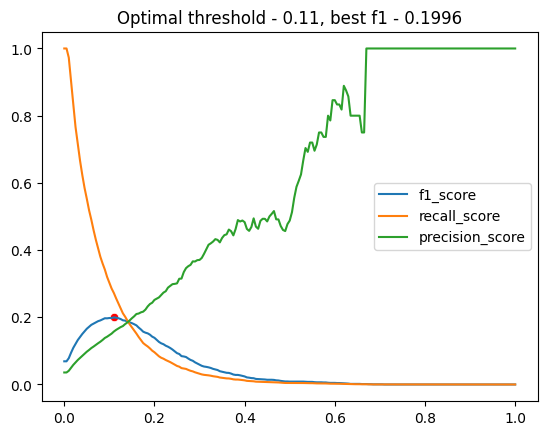

In [23]:
labels = ['f1_score', 'recall_score', 'precision_score']

for i in range(3):
    sns.lineplot(x=thresholds, y=metrics[:, i], label=labels[i])
sns.scatterplot(x=[best_threshold], y=[best_f1_score], color='red')
plt.title(f'Optimal threshold - {best_threshold:.2f}, best f1 - {best_f1_score:.4f}')

# LB prediction

In [24]:
# ensemble = ensemble.fit(X, y)
ensemble = pickle.load(open('/kaggle/input/model-lbb/model.pkl', 'rb'))

In [25]:
preds = []

for boosting in boostings:
    model = ensemble.named_estimators_[boosting]
    boosting_pred = model.predict_proba(X_test)[:, 1]
    boosting_pred = pd.Series(boosting_pred).rename(boosting)
    preds.append(boosting_pred)
    
preds = pd.concat(preds, axis=1)

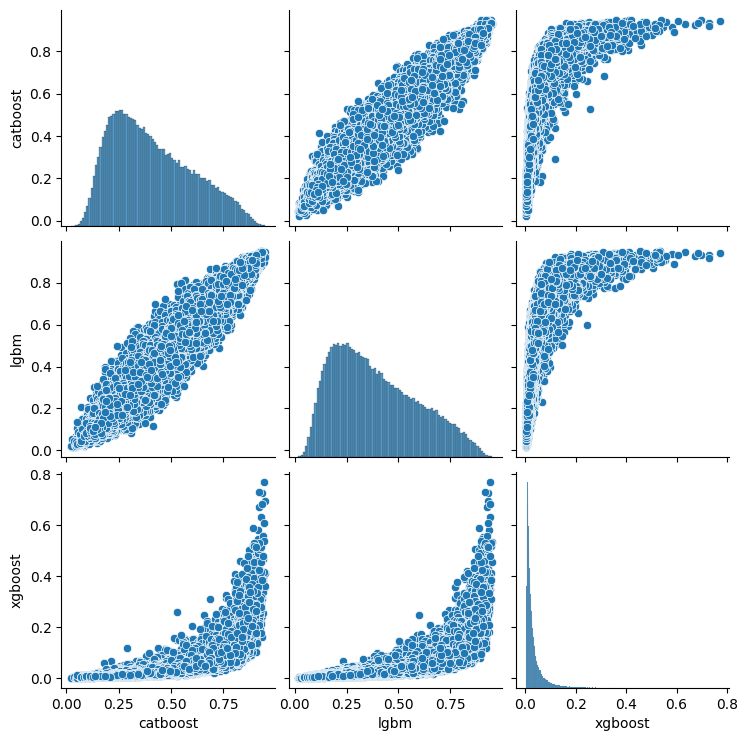

In [26]:
sns.pairplot(preds)

In [27]:
X_test.shape

(173433, 190)

In [28]:
preds = ensemble.predict_proba(X_test)[:, 1]

In [29]:
sub = pd.DataFrame([test_ids, (preds>best_threshold)*1, preds]).T

In [30]:
sub.columns = ['id', 'target_bin', 'target_prob']

In [31]:
sub.id = sub.id.astype(int)
sub.target_bin = sub.target_bin.astype(int)

In [32]:
sub.to_csv('submission.csv', index=False)